# The Battle of Neighborhoods (Week four, Part I)

### Description of the Business Problem:
We are working for a real estate agency which finds properties for companies and private individuals in Berlin. One contractor is a single guy after his studies to find a new flat. He wants to live in a neighborhood which has preferably bars, clubs and restaurants. The rental prices are supposed to be moderate at maximum. Our analysis has to find out, in which neighborhood our search starts.

### Description of the Data
Our analysis is going to use Foursquare location data, rental prices per square meter (see: miet-check.de) and zip codes (by: Simon Franzen). The Foursquare data consists of 5253 venues and 403 venue categories. The venue name and category (including geolocational data) is retrieved from Foursquare. Below is an overview about the different used data frames. In the end, a box plot of the rental prices is included. 

The goal is to cluster the neighborhood data and to select a cluster which is similar to our customer needs.

### Packages

In [1]:
# importing standard libraries
import pandas as pd
import numpy as np

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# library to handle requests
import requests

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Import done!')

Import done!


### Overview zip codes data frame

In [10]:
# source: https://github.com/zauberware/postal-codes-json-xml-csv/blob/master/data/DE/zipcodes.de.csv - by simonfranzen on github
zipcodes = pd.read_csv('zipcodes.csv')
zipcodes = zipcodes[['zipcode', 'state', 'latitude','longitude']]
zipcodes_berlin = zipcodes[zipcodes['state'] == 'Berlin']
zipcodes_berlin.reset_index(drop = True, inplace = True)

# Drop certain zipcodes (e.g. 11011 is the German Bundestag)
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 11011]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 13047]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 14053]
zipcodes_berlin = zipcodes_berlin[zipcodes_berlin['zipcode'] != 14131]

zipcodes_berlin.head()

,zipcode,state,latitude,longitude
0,10115,Berlin,52.5323,13.3846
1,10117,Berlin,52.5170,13.3872
2,10119,Berlin,52.5305,13.4053
3,10178,Berlin,52.5213,13.4096
4,10179,Berlin,52.5122,13.4164


### Import Venue Data

In [18]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ...
CLIENT_SECRET:...


In [4]:
# function to download first 100 avenues per zipcode
LIMIT = 100

def getNearbyVenues(zipcode, state, latitudes, longitudes, radius=1000):
    venues_list=[]
    print('Venue data is downloading...')
    for zipcode, state, lat, lng in zip(zipcode, state, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode',
                  'State',
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Venue data downloaded.')
    return(nearby_venues)

In [6]:
#run the above function on each neighborhood and create a new dataframe called venues_berlin
venues_berlin = getNearbyVenues(zipcode = zipcodes_berlin['zipcode'],
                                   state = zipcodes_berlin['state'],
                                   latitudes = zipcodes_berlin['latitude'],
                                   longitudes = zipcodes_berlin['longitude']
                                  )

Venue data is downloading...
Venue data downloaded.


### Overview Venue Data

In [12]:
# Venues in Berlin
print(f'Shape: {venues_berlin.shape}')
venues_berlin_clean = venues_berlin.copy()
venues_berlin_clean.drop_duplicates('Venue', keep='first', inplace=True)
venues_berlin_clean.sort_values(by = 'Zipcode', inplace = True)
print(f'Shape: {venues_berlin_clean.shape}')
venues_berlin_clean.reset_index([0], drop = True, inplace = True)
unique_venues = venues_berlin_clean['Venue Category'].nunique()
print(f'Total number of venues: {venues_berlin_clean.shape[0]}')
print(f'Total number of venue categories: {unique_venues}')

Shape: (9278, 8)
Shape: (5253, 8)
Total number of venues: 5253
Total number of venue categories: 403


In [14]:
venues_berlin.head(n=10)

,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,Berlin,52.5323,13.3846,Hotel i31,52.531107,13.384270,Hotel
1,10115,Berlin,52.5323,13.3846,Oslo Kaffebar,52.531029,13.386889,Coffee Shop
2,10115,Berlin,52.5323,13.3846,Titanic Chaussee Berlin,52.532215,13.381012,Hotel
3,10115,Berlin,52.5323,13.3846,BeachMitte,52.533821,13.384628,Volleyball Court
4,10115,Berlin,52.5323,13.3846,19grams,52.533037,13.380054,Coffee Shop
5,10115,Berlin,52.5323,13.3846,+84,52.532639,13.379511,Vegetarian / Vegan Restaurant
6,10115,Berlin,52.5323,13.3846,Museum für Naturkunde,52.530271,13.379281,Science Museum
7,10115,Berlin,52.5323,13.3846,Alnatura,52.528487,13.386047,Organic Grocery
8,10115,Berlin,52.5323,13.3846,Cô Chu Vietnamese Gourmet,52.531022,13.384755,Vietnamese Restaurant
9,10115,Berlin,52.5323,13.3846,Schnitzelei,52.528563,13.387228,Schnitzel Restaurant


### Overview and boxplot of rental prices 

In [15]:
# Source: https://www.miet-check.de
rental_prices = pd.read_csv('mietspiegel.csv', sep = ';')
rental_prices.head()

,Zipcode,Price
0,10115,22.28
1,10117,20.20
2,10119,21.38
3,10178,16.66
4,10179,22.82


In [16]:
# Functions to add the median value 
# Source: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
def add_median_labels(ax, precision='.1f'):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{precision}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

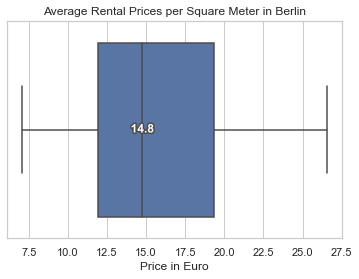

In [17]:
# Boxplot of rental prices:
sns.set_theme(style="whitegrid")

rental_prices_boxplot = sns.boxplot(x=rental_prices["Price"])
add_median_labels(rental_prices_boxplot.axes)

rental_prices_boxplot.set_title('Average Rental Prices per Square Meter in Berlin')
rental_prices_boxplot.set_xlabel('Price in Euro')

plt.show()